# Goal

Find out who is the most important person in Tayvat (that is not the Traveler) with network centrality measures.

# 1. Data Processing

Prepare the data for analysis.

Import relevant libraries:

In [1]:
import os

import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## 1.1 Read Data

Read data file from kaggle:

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genshin-impact-voicelines/genshin_en_voicelines_v2.csv


In [3]:
df = pd.read_csv('/kaggle/input/genshin-impact-voicelines/genshin_en_voicelines_v2.csv')

In [4]:
# preview dataframe
df.head(3)

,id,character,title,voice_line,requirements,about,nation
0,0,Tighnari,Hello,"Hi there. I'm Tighnari, Forest Watcher of the ...",NaN,NaN,Sumeru
1,1,Tighnari,Chat: Leaf Bookmark,If you press a leaf between dry sheets of pape...,NaN,NaN,Sumeru
2,2,Tighnari,Chat: Mistakes,Don't be afraid to make mistakes. It's all par...,NaN,NaN,Sumeru


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3788 entries, 0 to 3787
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3788 non-null   int64 
 1   character     3788 non-null   object
 2   title         3788 non-null   object
 3   voice_line    3788 non-null   object
 4   requirements  1753 non-null   object
 5   about         797 non-null    object
 6   nation        3756 non-null   object
dtypes: int64(1), object(6)
memory usage: 207.3+ KB


## 1.2 Process Data

Filter out Aloy's voicelines; Aloy will not be included in the analysis as she is a character that was added to the game for a collab and does not interact with any other playable characters in the game.

In [6]:
# ignore Aloy's voicelines
df = df[df['character'] != 'Aloy'].reset_index(drop=True)

Supplement `about` column

In [7]:
df[df['about']=='Alice']

,id,character,title,voice_line,requirements,about,nation
758,790,Dori,About Alice,Alice's range of eccentric novelties knows no ...,Friendship Lv. 4,Alice,Sumeru


In [8]:
df[(df['character']=='Albedo') & (df['title']=='About Family')]

,id,character,title,voice_line,requirements,about,nation
656,688,Albedo,About Family,Family? Although Alice has always asked me to ...,Friendship Lv. 6,NaN,Mondstadt


🔼 Notice above that while 'Alice' (Klee's mum) is only reflected in the 'about' column for Dori (extracted from the title being 'About Alice'), other people who are likely to mention Alice such as Albedo (who Alice adopted) do not have her in the 'about' column.

To add a little more information to the network graph, the 'about' column will be supplemented by extracting characters from the 'voice_line' column.

In [9]:
# get list of characters to check for 
about_characters = [i for i in list(df['about'].unique()) if i is not np.nan]

Supporting functions

In [10]:
# supplement 'about' column
def get_characters_from_voiceline(voiceline):
    '''checks voicelines for any characters that might have been missed'''
    noted_characters = []
    for chara in about_characters:
        if chara in voiceline: noted_characters.append(chara)
    return noted_characters

def add_about(row):
    '''combine characters in the 'about' column and any additional characters detected in the voice line itself'''
    all_about = row['about']
    additional_about = get_characters_from_voiceline(row['voice_line'])
    all_about.extend(additional_about)
    if '' in all_about: all_about.remove('') # remove any empty strings
    if row['character'] in all_about: all_about.remove(row['character'])    # prevent character from being in their own 'about' column
    if all_about: row['about'] = [a.strip() for a in list(set(all_about))]
    return row

In [11]:
# split the string in the about column to make a list
df['about'] = df['about'].apply(lambda x: x.split(';') if x is not np.nan else [])

In [12]:
# apply add_about function
df = df.apply(lambda r: add_about(r), axis=1)

In [13]:
# separate each list element in 'about' column to be its own row
df = df.explode('about').reset_index(drop=True)

In [14]:
# check number of rows with non-empty 'about' column
df[df['about'].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 22 to 3829
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            935 non-null    int64 
 1   character     935 non-null    object
 2   title         935 non-null    object
 3   voice_line    935 non-null    object
 4   requirements  887 non-null    object
 5   about         935 non-null    object
 6   nation        935 non-null    object
dtypes: int64(1), object(6)
memory usage: 58.4+ KB


In [15]:
# check that there are more characters mentioning Alice
df[df['about']=='Alice']

,id,character,title,voice_line,requirements,about,nation
673,688,Albedo,About Family,Family? Although Alice has always asked me to ...,Friendship Lv. 6,Alice,Mondstadt
677,692,Albedo,About Klee,"Indeed, I view Klee as my younger sister. When...",Friendship Lv. 4,Alice,Mondstadt
777,790,Dori,About Alice,Alice's range of eccentric novelties knows no ...,Friendship Lv. 4,Alice,Sumeru
878,889,Barbara,More About Barbara: III,"Being an idol, I learned from Alice that ""A tr...",Friendship Lv. 4,Alice,Mondstadt
3508,3473,Mona,About Klee,"Ah yes, Alice's daughter. She's in the custody...",Friendship Lv. 4,Alice,Mondstadt


## 1.3 Create Edgelist

In [16]:
# create edgelist with weight 
edges = df[~df.about.isna()][['character', 'about', 'title', 'nation']].groupby(by=['character',  'about', 'nation']).count().reset_index()

# rename columns
edges.rename(columns={'character': 'source', 'about': 'target', 'title': 'weight'}, inplace=True)

In [17]:
# display top 10 edges by weight
edges.sort_values(by='weight', ascending=False).head(10)

,source,target,nation,weight
417,Lyney,Lynette,Fontaine,9
407,Lynette,Lyney,Fontaine,9
719,Yaoyao,Xiangling,Liyue,6
130,Collei,Amber,Sumeru,6
20,Amber,Jean,Mondstadt,6
214,Freminet,Lyney,Fontaine,6
355,Klee,Jean,Mondstadt,5
575,Tartaglia,Tsaritsa,Snezhnaya,4
54,Baizhu,Qiqi,Liyue,4
366,Kujou Sara,Raiden Shogun,Inazuma,4


# 2. Directed Graph

## 2.1 Build Directed Graph

Reference mappings:

In [18]:
# mapping for nation to colours for node display
NATION_COLOUR_MAPPING = {
    'Mondstadt': '#74f3dd',
    'Liyue': '#ebc027',
    'Inazuma': '#b863cb',
    'Sumeru': '#7efd83',
    'Fontaine': '#009dff',
    'Snezhnaya': '#80e3fe'
}

In [19]:
NATION_MAP = {
    'Jean': 'Mondstadt',
    'Raiden Shogun': 'Inazuma',
    'Yanfei': 'Liyue',
    'Alhaitham': 'Sumeru',
    'Mona': 'Mondstadt',
    'Wriothesley': 'Fontaine',
    'Kaeya': 'Mondstadt',
    'Kuki Shinobu': 'Inazuma',
    'Yaoyao': 'Liyue',
    'Xiao': 'Liyue',
    'Tartaglia': 'Snezhnaya',
    'Sayu': 'Inazuma',
    'Layla': 'Sumeru',
    'Razor': 'Mondstadt',
    'Candace': 'Sumeru',
    'Yun Jin': 'Liyue',
    'Mika': 'Mondstadt',
    'Gorou': 'Inazuma',
    'Lisa': 'Mondstadt',
    'Freminet': 'Fontaine',
    'Sangonomiya Kokomi': 'Inazuma',
    'Xinyan': 'Liyue',
    'Charlotte': 'Fontaine',
    'Kaedehara Kazuha': 'Inazuma',
    'Arlecchino': 'Fontaine',
    'Baizhu': 'Liyue',
    'Diona': 'Mondstadt',
    'Noelle': 'Mondstadt',
    'Navia': 'Fontaine',
    'Cyno': 'Sumeru',
    'Nilou': 'Sumeru',
    'Yoimiya': 'Inazuma',
    'Gaming': 'Liyue',
    'Yae Miko': 'Inazuma',
    'Ganyu': 'Liyue',
    'Fischl': 'Mondstadt',
    'Shikanoin Heizou': 'Inazuma',
    'Zhongli': 'Liyue',
    'Beidou': 'Liyue',
    'Sucrose': 'Mondstadt',
    'Xingqiu': 'Liyue',
    'Yelan': 'Liyue',
    'Eula': 'Mondstadt',
    'Wanderer': 'Sumeru',
    'Kamisato Ayaka': 'Inazuma',
    'Lynette': 'Fontaine',
    'Keqing': 'Liyue',
    'Kujou Sara': 'Inazuma',
    'Bennett': 'Mondstadt',
    'Dehya': 'Sumeru',
    'Xiangling': 'Liyue',
    'Diluc': 'Mondstadt',
    'Nahida': 'Sumeru',
    'Qiqi': 'Liyue',
    'Chiori': 'Fontaine',
    'Tighnari': 'Sumeru',
    'Neuvillette': 'Fontaine',
    'Chevreuse': 'Fontaine',
    'Ningguang': 'Liyue',
    'Klee': 'Mondstadt',
    'Lyney': 'Fontaine',
    'Xianyun': 'Liyue',
    'Venti': 'Mondstadt',
    'Shenhe': 'Liyue',
    'Kirara': 'Inazuma',
    'Thoma': 'Inazuma',
    'Hu Tao': 'Liyue',
    'Kaveh': 'Sumeru',
    'Albedo': 'Mondstadt',
    'Dori': 'Sumeru',
    'Rosaria': 'Mondstadt',
    'Faruzan': 'Sumeru',
    'Chongyun': 'Liyue',
    'Barbara': 'Mondstadt',
    'Amber': 'Mondstadt',
    'Furina': 'Fontaine',
    'Arataki Itto': 'Inazuma',
    'Collei': 'Sumeru',
    'Kamisato Ayato': 'Inazuma',
    'Aloy': 'NA',
    'Traveler': 'NA',
    # tbd
    'Clorinde': 'Fontaine', 
    'Sigewinne': 'Fontaine',
    'Pierro': 'Snezhnaya',
    'Il Capitano': 'Snezhnaya',
    'Il Dottore': 'Snezhnaya',
    'Columbina': 'Snezhnaya',
    'Pulcinella': 'Snezhnaya',
    'Sandrone': 'Snezhnaya',
    'Pantalone': 'Snezhnaya',
    'Varka': 'Mondstadt',         
    'Tsaritsa': 'Snezhnaya',
    'Alice': 'Mondstadt',
    'Moon Carver': 'Liyue',
    'Madame Ping': 'Liyue'
}

In [20]:
# build directed graph
DG = nx.from_pandas_edgelist(edges,
                            source='source',
                            target='target',
                            edge_attr='weight',
                            create_using=nx.DiGraph()
                            )
str(DG)

'DiGraph with 93 nodes and 762 edges'

In [21]:
# set 'nation' attribute for nodes
nx.set_node_attributes(DG, NATION_MAP, name='nation')

Assign a colour to each node based on their nation attribute

In [22]:
node_colors = []
for node, nation in list(DG.nodes(data="nation")):
    if nation in NATION_COLOUR_MAPPING.keys():
        node_colors.append(NATION_COLOUR_MAPPING[nation])
    else:
        node_colors.append('#b8b8b8') # doesn't belong to any nation / character's traits are not confirmed yet

Draw directed graph

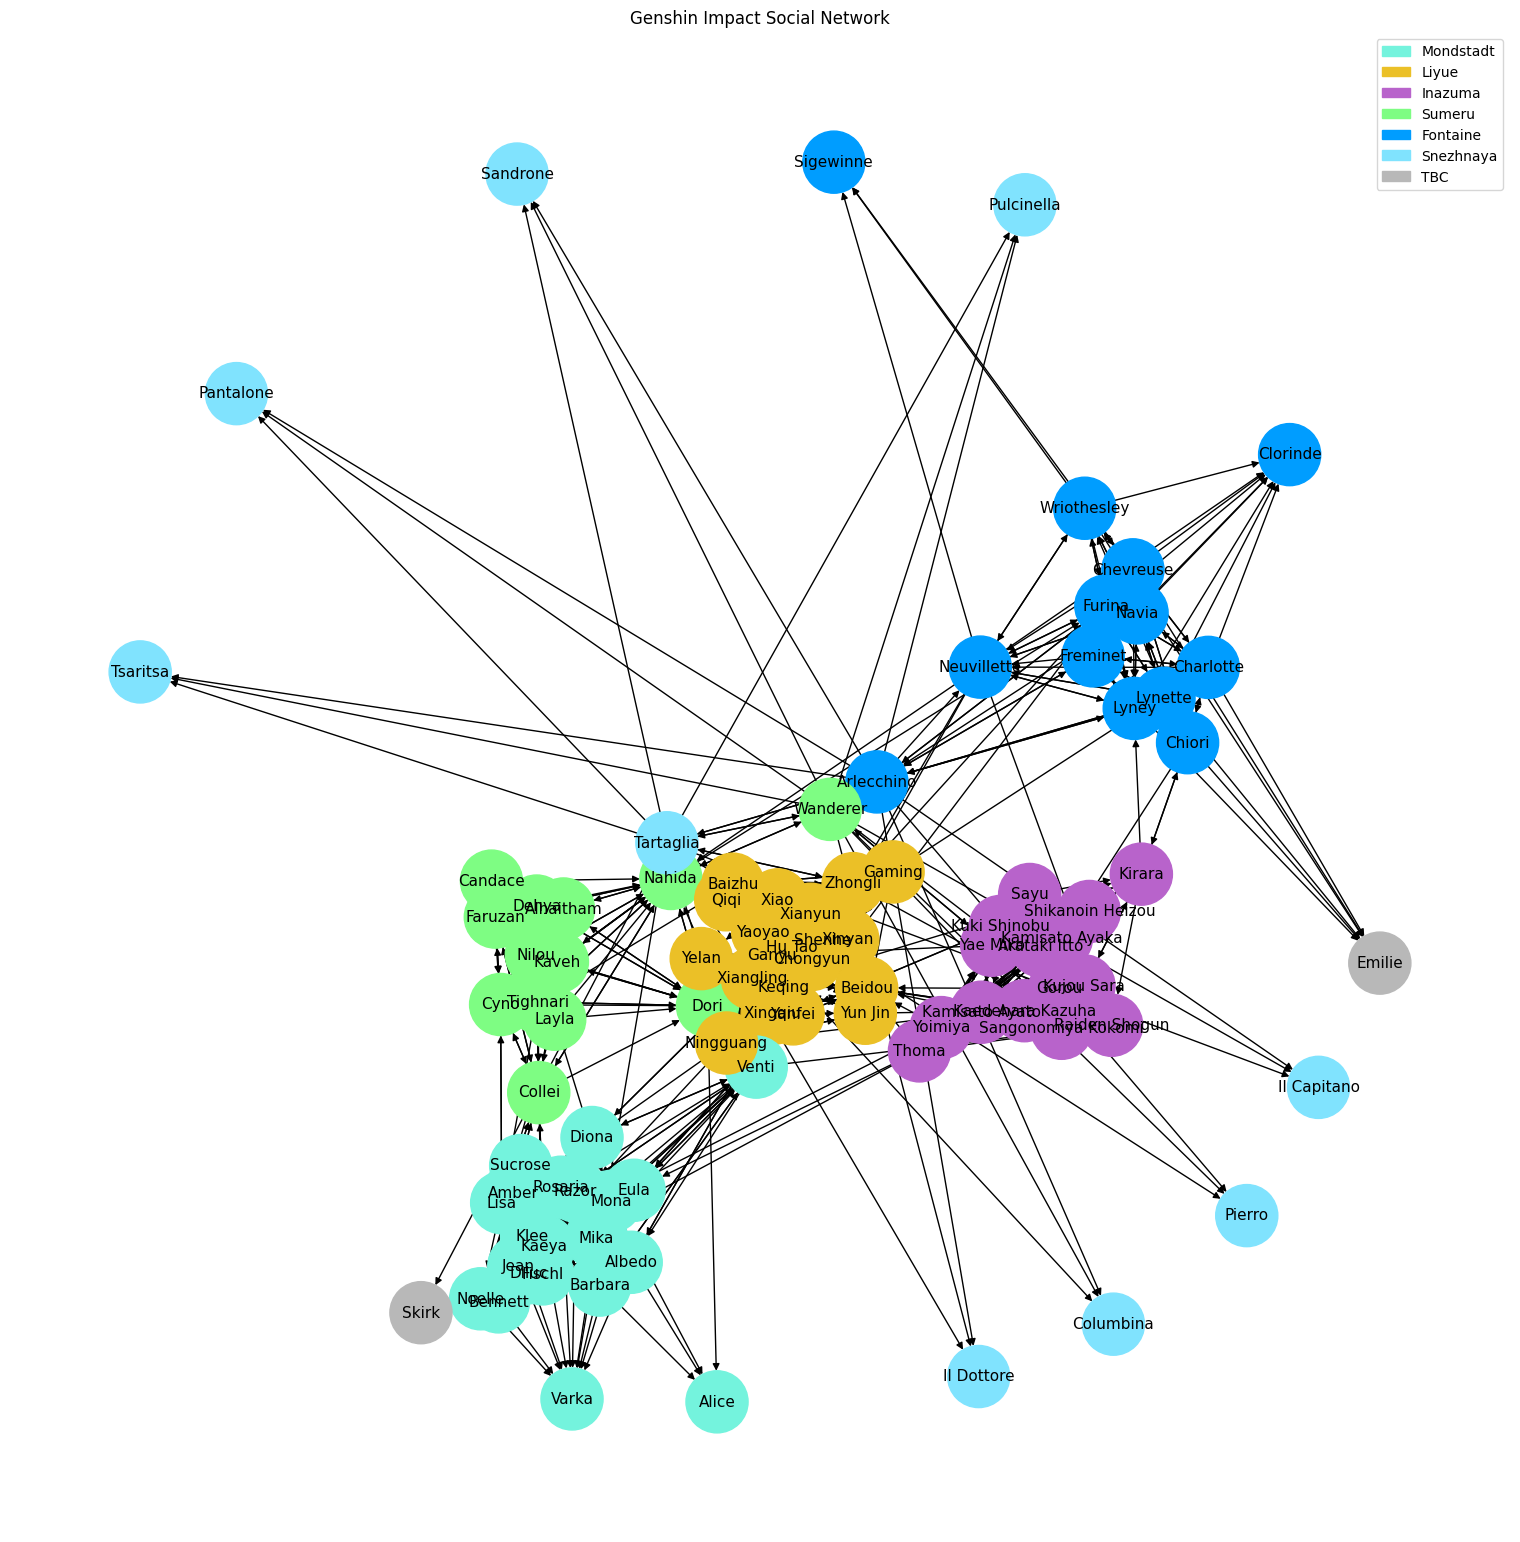

In [23]:
np.random.seed(2000)    # to keep diagram generated fixed o
pos = nx.spring_layout(DG, k=1.25, iterations=250)

plt.figure(1,figsize=(15,15)) 
nx.draw(DG,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend
legend_tiles = [mpatches.Patch(color=v, label=k) for k, v in NATION_COLOUR_MAPPING.items()]
legend_tiles.append(mpatches.Patch(color="#b8b8b8", label="TBC"))

plt.title("Genshin Impact Social Network")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()

# uncomment to save picture
# plt.savefig('directed_graph.png')

<u>Directed Network Observations</u>
* There are a number of mentions that are not reciprocated (one-way):
  * e.g. Chiori → Shikanoin Heizou but there does not exist a tie going the other way, suggesting that Chiori mentions and hence is implied to know Heizou but Heizou does not know Chiori. Similarly for Layla → Dori.
  * This lack of reciprocity might be due to some characters not being released yet and thus not having voiceline data
  * The only way to know anything about the character Skirk, is via Tartaglia
  * This can be a way to predict how new characters will be introduced to the player
    * e.g. A character that is widely mentioned but has not been seen yet is Emilie, a perfumer according to voicelines. Given that most characters that mention Emilie are characters from Fontaine, she is likely to either be Fontaine character or a character that links another nation to Fontaine

### 2.1.1 Network Density

In [24]:
nx.density(DG)

0.08906030855539972

The (directed network) has a density of 0.0891, implying that of all the possible connections (edges) that the network can have, the genshin impact network consists of 8.91% of them. 

## 2.2 Character Importance Measures

### 2.2.1 In-Degree Centrality

A character is more central (important) to a network if they have a lot of other characters mentioning them.

A higher in-degree centrality implies that a character is more popular and more important in a network.

In [25]:
# build summary dataframe
summary_df = pd.DataFrame(data=list(DG.nodes) ,columns=['character'])

# add nation column to summary_df
summary_df['nation'] = summary_df['character'].apply(lambda x: NATION_MAP[x] if x in NATION_MAP.keys() else 'NA')

In [26]:
# add in-degree centrality
summary_df['in_degree'] = summary_df['character'].apply(lambda n: DG.in_degree(n))

In [27]:
# average in-degree
summary_df['in_degree'].mean()

8.193548387096774

Each character has about 8 other characters mentioning them.

In [28]:
# display top 10 characters with the highest in-degree centrality
summary_df.sort_values(by='in_degree', ascending=False).head(10)

,character,nation,in_degree
58,Zhongli,Liyue,20
6,Lisa,Mondstadt,19
30,Raiden Shogun,Inazuma,18
3,Jean,Mondstadt,18
15,Nahida,Sumeru,15
62,Beidou,Liyue,15
63,Ningguang,Liyue,14
5,Klee,Mondstadt,14
4,Kaeya,Mondstadt,13
33,Yae Miko,Inazuma,13


### 2.2.2 Out-Degree Centrality

A character is more central (important) to a network if they _know_ a lot of other characters.

A higher out-degree centrality implies that a character is knows more characters in the network.

In [29]:
# add out-degree centrality
summary_df['out_degree'] = summary_df['character'].apply(lambda n: DG.out_degree(n))

In [30]:
# average out-degree
summary_df['out_degree'].mean()

8.193548387096774

Each character knows about 8 other characters.

(The in-degree and out-degree centralities seem to have the same mean value, curious...)

In [31]:
# display top 10 characters with the highest out-degree centrality
summary_df[['character', 'nation', 'out_degree']].sort_values(by='out_degree', ascending=False).head(10)

,character,nation,out_degree
9,Xingqiu,Liyue,14
35,Arlecchino,Fontaine,14
4,Kaeya,Mondstadt,14
63,Ningguang,Liyue,14
6,Lisa,Mondstadt,14
91,Wanderer,Sumeru,14
48,Tartaglia,Snezhnaya,13
64,Xiangling,Liyue,13
21,Eula,Mondstadt,13
33,Yae Miko,Inazuma,13


### 2.2.3 Page Rank Centrality

Adds an additional consideration for influence — what matters more than the number of characters mentioning a character (in-degree) is how many influential ties are in-coming.

A higher page rank centrality value suggests that a character is connected to more influencial characters and has a wider reach beyond their direct ties.

In [32]:
# add page rank centrality
summary_df['page_rank'] = summary_df['character'].apply(lambda n: nx.pagerank(DG)[n])

In [33]:
# display top 10 characters with the highest page rank centrality
summary_df[['character', 'nation', 'page_rank']].sort_values(by='page_rank', ascending=False).head(10)

,character,nation,page_rank
3,Jean,Mondstadt,0.029585
30,Raiden Shogun,Inazuma,0.027573
6,Lisa,Mondstadt,0.023387
58,Zhongli,Liyue,0.020779
28,Kujou Sara,Inazuma,0.020043
63,Ningguang,Liyue,0.019998
62,Beidou,Liyue,0.019212
64,Xiangling,Liyue,0.018423
52,Ganyu,Liyue,0.017540
0,Albedo,Mondstadt,0.017500


# 3. Undirected Graph

## 3.1. Build Undirected Graph

fom the directed graph  only considering reciprocal ties (both characters are considered to have a tie if the both mention each other).

In [34]:
UG = DG.to_undirected(reciprocal=True)

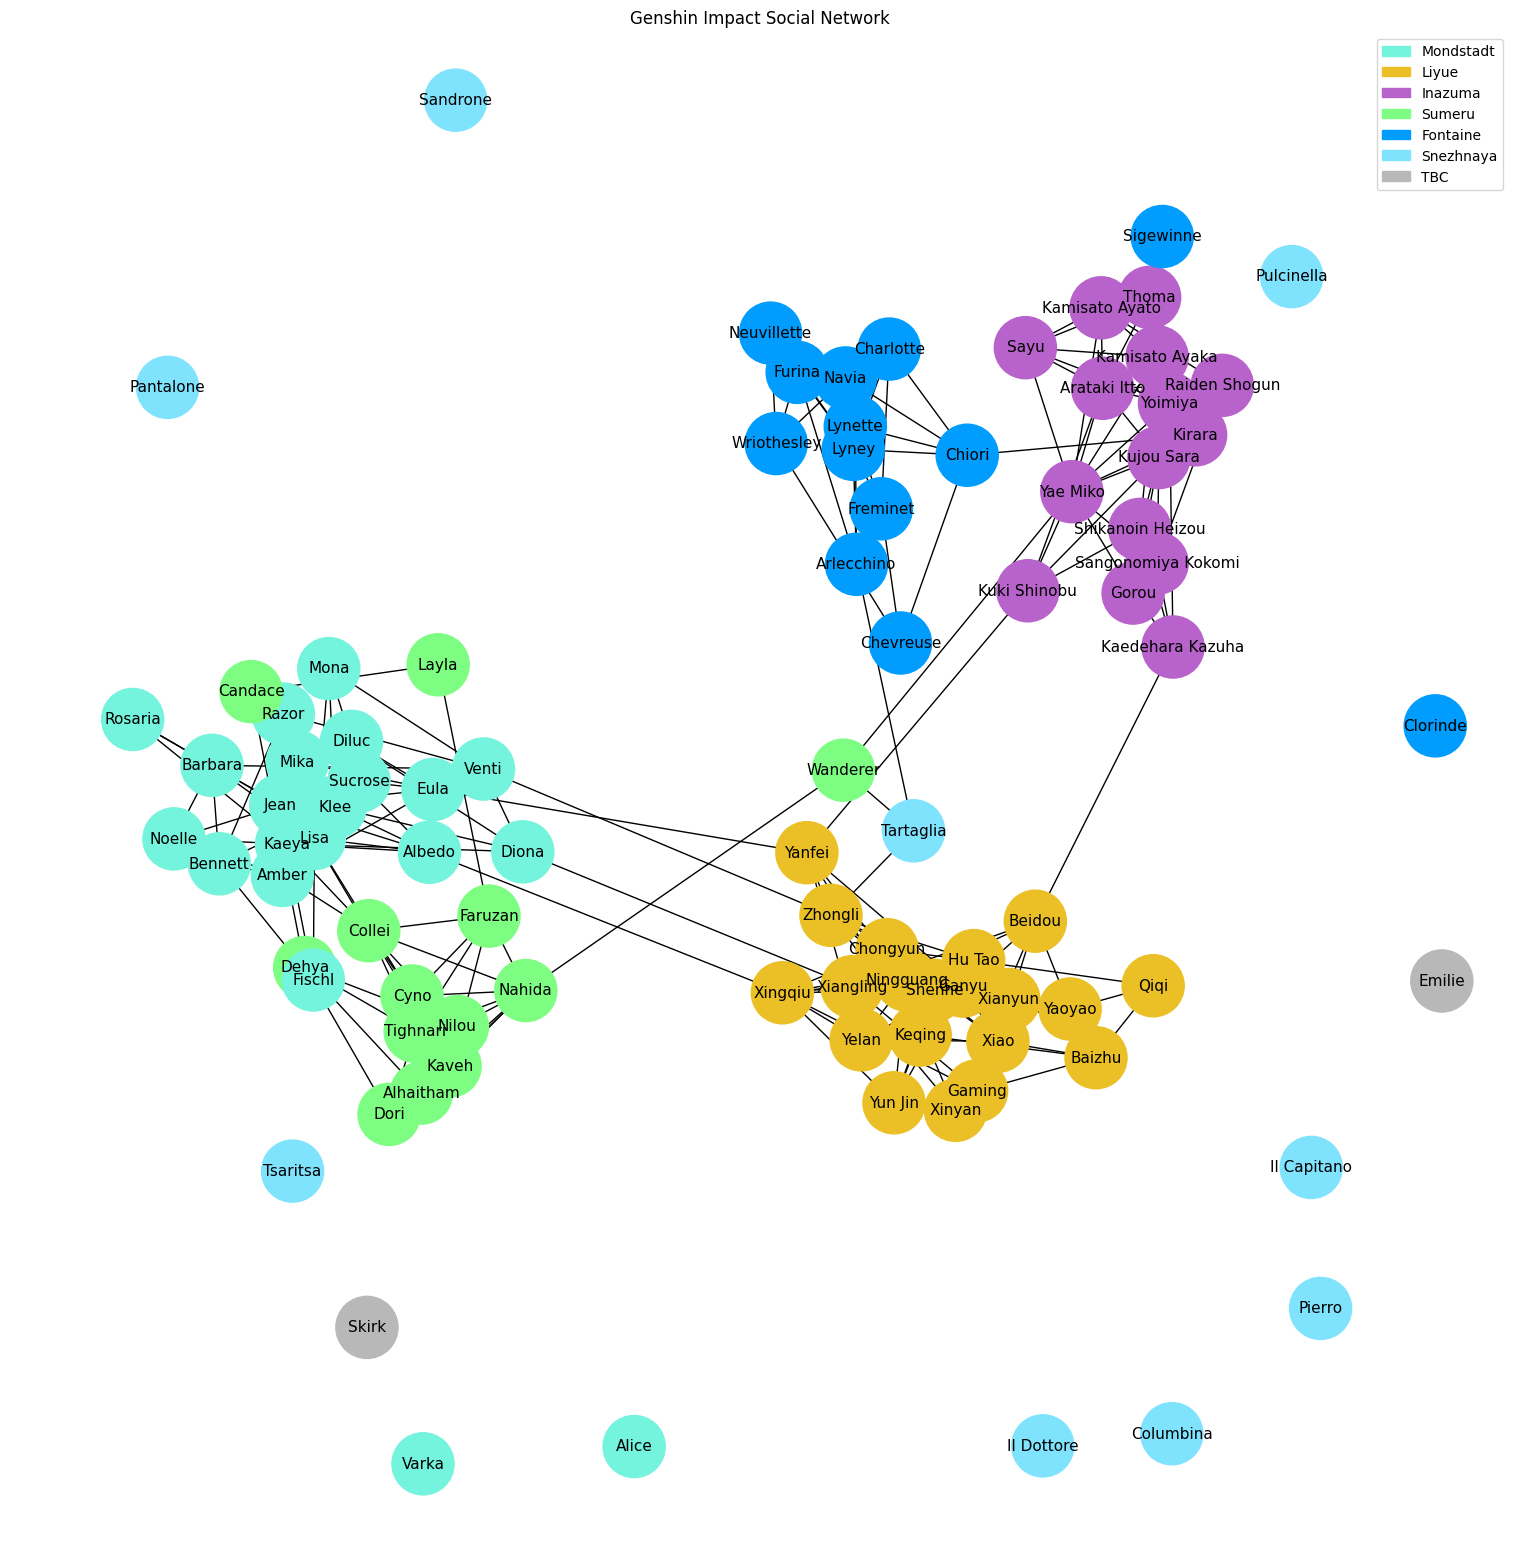

In [35]:
np.random.seed(2000)
pos = nx.spring_layout(UG, k=0.3, iterations=45)

plt.figure(1,figsize=(15,15)) 
nx.draw(UG,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend
legend_tiles = [mpatches.Patch(color=v, label=k) for k, v in NATION_COLOUR_MAPPING.items()]
legend_tiles.append(mpatches.Patch(color="#b8b8b8", label="TBC"))

plt.title("Genshin Impact Social Network")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()

# uncomment to save picture
# plt.savefig('undirected.png')

<u>Undirected Network Observations</u>

Making the graph undirected and enforcing that ties (edges) be mutual, caused the graph to have isolates (not connected to the rest of the network).

Isolated character are unlikely to be important players in the network (at this point) and will be removed for further analysis.

In [36]:
# remove isolates (characters not connected to any other characters)
UG.remove_nodes_from(list(nx.isolates(UG)))

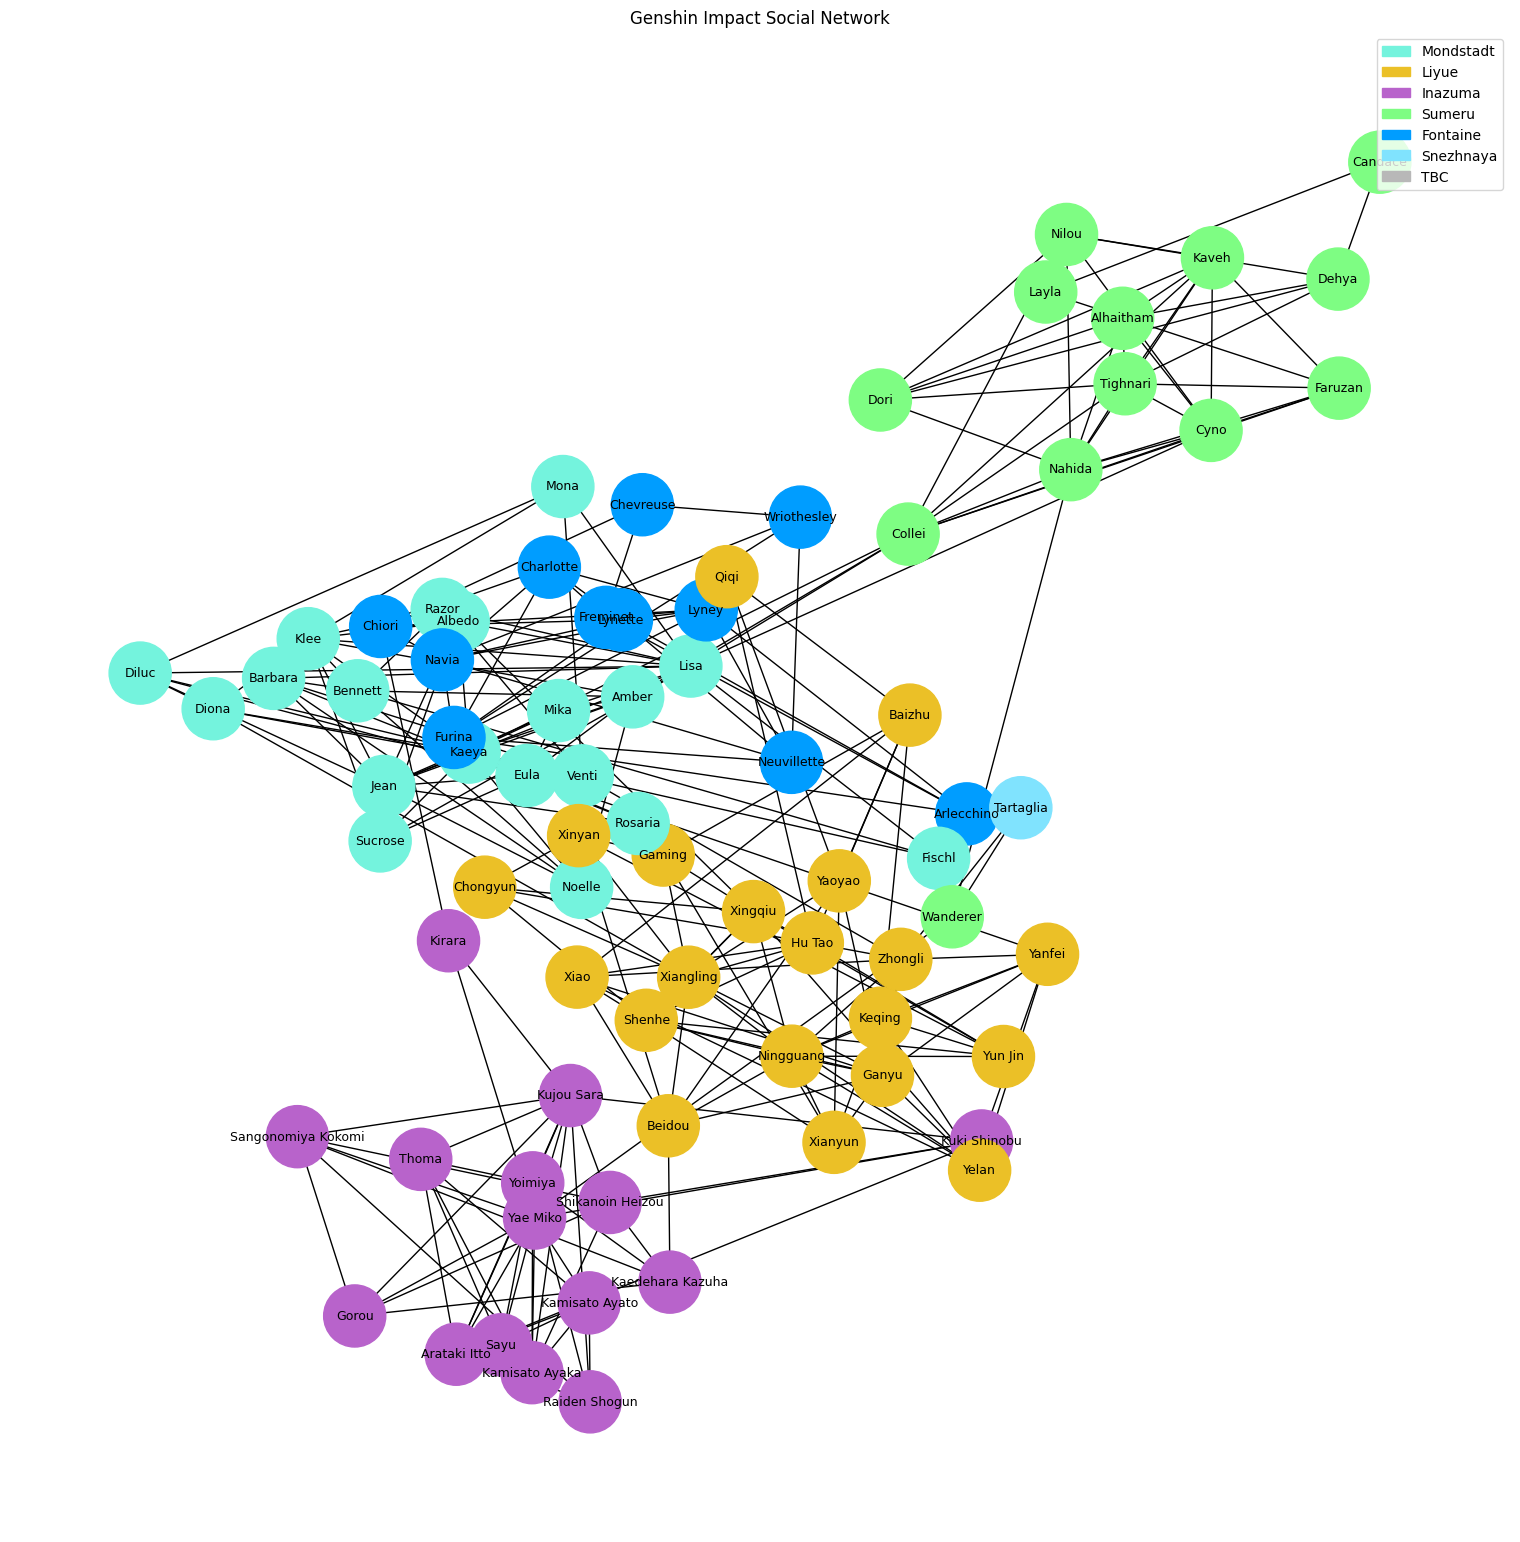

In [37]:
# redo node colours list
node_colors = []
for node, nation in list(UG.nodes(data="nation")):
    if nation in NATION_COLOUR_MAPPING.keys():
        node_colors.append(NATION_COLOUR_MAPPING[nation])
    else:
        node_colors.append('#b8b8b8') # doesn't belong to any nation / not seen yet
        
pos = nx.spring_layout(DG, k=0.5, iterations=40)

plt.figure(1,figsize=(15,15)) 
nx.draw(UG,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 9,
        font_color='black')

# create legend
legend_tiles = [mpatches.Patch(color=v, label=k) for k, v in NATION_COLOUR_MAPPING.items()]
legend_tiles.append(mpatches.Patch(color="#b8b8b8", label="TBC"))

plt.title("Genshin Impact Social Network")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()

# uncomment to save picture
# plt.savefig('undirected without isolates.png')

### 3.1.1 Minimum Cut Nodes

Which character(s) when removed from the network, causes fractures in the network?

In [38]:
nx.minimum_node_cut(UG)

{'Candace', 'Faruzan'}

If Candace and Faruzan are removed from the network, someone will be isolated from the network (it's Layla).

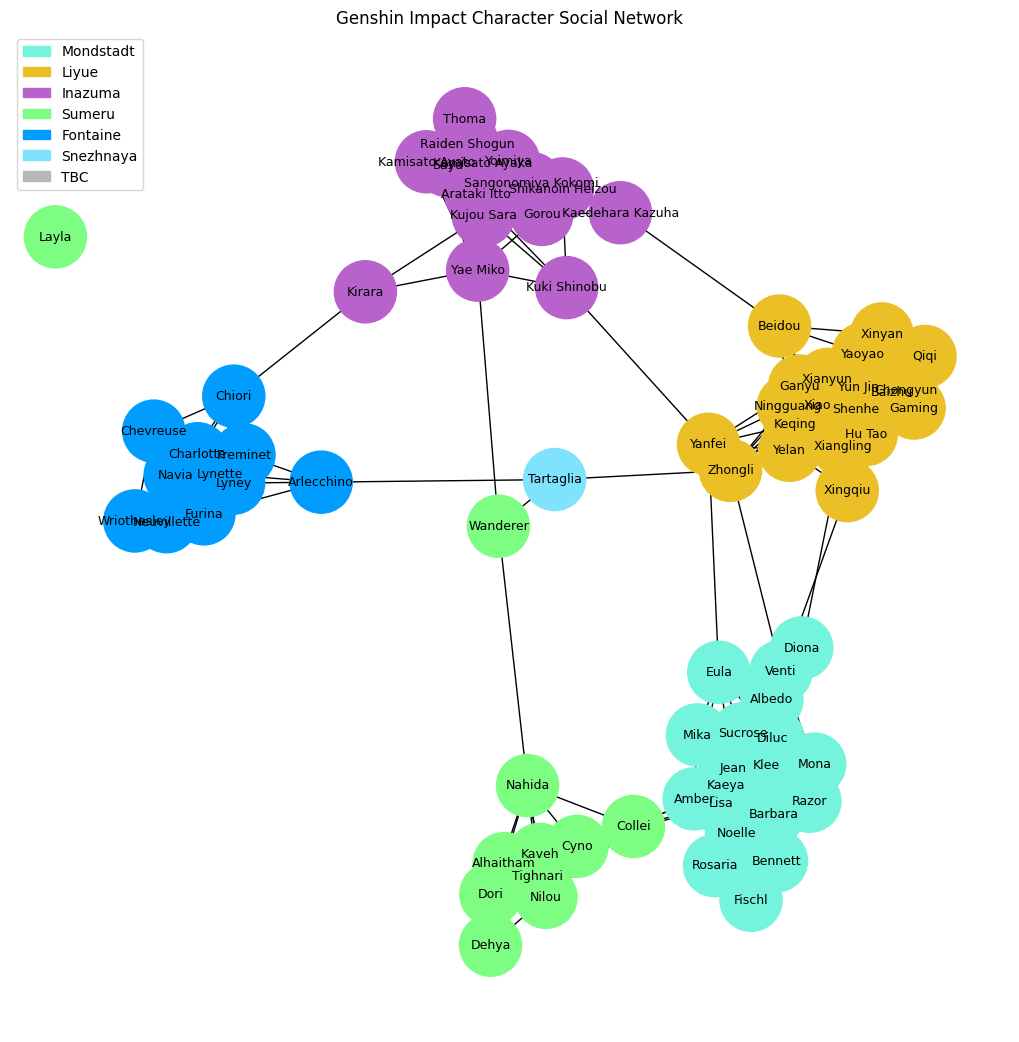

In [39]:
# see a network without Candace and Faruzen
temp_copy = UG.copy()
temp_copy.remove_nodes_from(['Candace', 'Faruzan'])
temp_copy.nodes()

node_colors = []
for node, nation in list(temp_copy.nodes(data="nation")):
    if nation in NATION_COLOUR_MAPPING.keys():
        node_colors.append(NATION_COLOUR_MAPPING[nation])
    else:
        node_colors.append('#b8b8b8') # doesn't belong to any nation / not seen yet
np.random.seed(2021)
pos = nx.spring_layout(temp_copy, k=0.3, iterations=75)

plt.figure(1,figsize=(10,10)) 
nx.draw(temp_copy,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 9,
        font_color='black')

# create legend
legend_tiles = [mpatches.Patch(color=v, label=k) for k, v in NATION_COLOUR_MAPPING.items()]
legend_tiles.append(mpatches.Patch(color="#b8b8b8", label="TBC"))

plt.title("Genshin Impact Character Social Network")
plt.legend(handles=legend_tiles, loc="upper left")
plt.show()

## 3.2 Node Importance Measures

### 3.2.1 Closeness Centrality

Measures the average of the shortest path length of a character to every other character in the network.
 
Closeness centrality can be calculated with a directed graph but just because a character talks about another character doesn't make them able to transmit information if they do not mutually know each other - which is the reason this measure is calculated with the undirected graph.

In [40]:
# add closeness centrality
summary_df['closeness'] = summary_df['character'].apply(lambda n: nx.closeness_centrality(UG)[n] if n in list(UG.nodes) else np.nan)

In [41]:
# display top 10 characters with the highest closeness centrality
summary_df[['character', 'nation', 'closeness']].sort_values(by='closeness', ascending=False).head(10)

,character,nation,closeness
58,Zhongli,Liyue,0.342105
86,Yanfei,Liyue,0.336207
48,Tartaglia,Snezhnaya,0.329114
91,Wanderer,Sumeru,0.322314
63,Ningguang,Liyue,0.313253
21,Eula,Mondstadt,0.313253
52,Ganyu,Liyue,0.310757
29,Kuki Shinobu,Inazuma,0.308300
64,Xiangling,Liyue,0.308300
61,Venti,Mondstadt,0.304688


### 3.2.2 Betweenness Centrality

Measures the extent in which a character is in the shortest path between other characters.
 
A character with a higher betweenness centrality score has more influence in the network given that they stand between information flow between other characters more often.

In [42]:
# add betweenness centrality
summary_df['betweenness'] = summary_df['character'].apply(lambda n: nx.betweenness_centrality(UG)[n] if n in list(UG.nodes) else np.nan)

In [43]:
# display top 10 characters with the highest betweenness centrality
summary_df[['character', 'nation', 'betweenness']].sort_values(by='betweenness', ascending=False).head(10)

,character,nation,betweenness
48,Tartaglia,Snezhnaya,0.208801
58,Zhongli,Liyue,0.203412
91,Wanderer,Sumeru,0.164237
35,Arlecchino,Fontaine,0.158772
15,Nahida,Sumeru,0.150971
86,Yanfei,Liyue,0.144737
33,Yae Miko,Inazuma,0.140601
29,Kuki Shinobu,Inazuma,0.106180
20,Collei,Sumeru,0.101264
21,Eula,Mondstadt,0.097749


<u>Observations</u>
* Currently playable Fatui characters such as Tartaglia, Wanderer and Arlecchino might have high betweenness centrality values as they are the only characters that bridge the network to any other unreleased Fatui harbringers (see: 2. Directed Graph above)

# 4. Synthesis

Add a ranking for the characters for each measure of centrality (importance). 

In [44]:
# fill NaN with 0
summary_df = summary_df.fillna(0)

In [45]:
# add ranks based on different centrality values

# directed graph measures
summary_df['in_degree_rank'] = summary_df['in_degree'].rank(method='first', ascending=False).astype(int)
summary_df['out_degree_rank'] = summary_df['out_degree'].rank(method='first', ascending=False).astype(int)
summary_df['page_rank_rank'] = summary_df['page_rank'].rank(method='first', ascending=False).astype(int)

# undirected graph measures
summary_df['closeness_rank'] = summary_df['closeness'].rank(method='first', ascending=False).astype(int)
summary_df['betweenness_rank'] = summary_df['betweenness'].rank(method='first', ascending=False).astype(int)

In [46]:
rank_df = summary_df.filter(regex='(character)|(nation)|(_rank$)', axis=1).drop(columns=['page_rank'])   # filter only rank columns

In [47]:
# add average rank column
rank_df['average_rank'] = rank_df.mean(numeric_only=True, axis=1)
rank_df.sort_values('average_rank').style.background_gradient(subset=list(rank_df.columns[2:]), cmap='GnBu')
# rank_df.sort_values('average_rank').style.background_gradient(axis=0, gmap=rank_df['average_rank'], cmap='magma') # uncomment to highlight the entire row based on average_rank value

,character,nation,in_degree_rank,out_degree_rank,page_rank_rank,closeness_rank,betweenness_rank,average_rank
58,Zhongli,Liyue,1,16,4,1,2,4.800000
6,Lisa,Mondstadt,2,2,3,19,12,7.600000
63,Ningguang,Liyue,8,5,6,6,25,10.000000
4,Kaeya,Mondstadt,9,1,13,17,14,10.800000
64,Xiangling,Liyue,13,12,8,9,13,11.000000
33,Yae Miko,Inazuma,11,9,23,10,7,12.000000
3,Jean,Mondstadt,3,7,1,24,33,13.600000
52,Ganyu,Liyue,12,14,9,7,29,14.200000
15,Nahida,Sumeru,5,29,19,13,5,14.200000
9,Xingqiu,Liyue,16,3,24,14,15,14.400000


### 4.1 Conclusion

The most important person in the genshin impact network currently is likely to be <mark>Zhongli</mark>, with the highest average rank (lowest value in `average_rank` collumn).

Zhongli is not only at the centre of the network in terms of popularity (highest in-degree centrality), the characters he knows are also of high influence in the network (top 5 in page rank centrality).

Additionally, he is also in a good position in the network to spread information, being the prime character to spread information to the rest of the network (highest in closeness centrality) and also receive information (2nd highest in betweenness centrality)

## 4.2 Further Analysis

* Adding a hub and authority measures may help to understand which characters are information authorities in the network

## 4.3 Resources

[Social Network Analysis: From Graph Theory to Applications with Python](https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7) - basics of social network analysis

[Genshin Network Analysis](https://www.kaggle.com/code/riasingh12/genshin-network-analysis/notebook) - another analysis 

[原神人物网络图 / social network graph of Genshin characters](https://github.com/King-of-Infinite-Space/genshin-social-network?tab=readme-ov-file) - an interactive version of the genshin impact social network